<a href="https://colab.research.google.com/github/stazam/DTSE-project/blob/main/DTSE_steam_data_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment**: steam reviews prediction 

In this scenario imagine you work as a Data Scientist for Steam gaming platform. Your task is to download historical game review data from https://www.kaggle.com/whoiskk/steam-game-reviews and prepare a ML model which will be used to predict "user suggestion" category for future game reviews in production. Please use Python. 
There are 4 datasets total:
-          game_overview.csv
-          sample_submission.csv
-          test.csv
-          train.csv

<br></br>
Content of this notebook:
1. Quick data exploration
2. Model building 
3. Checking the performance 
4. Optimization
5. Time performance. 

In [10]:
import tensorflow as tf
import keras
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

from keras import applications
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional
from keras.layers import Convolution2D, MaxPooling2D,BatchNormalization,GlobalAveragePooling1D, Flatten, Dropout
from keras import optimizers

In [11]:
#from google.colab import files 

#uploaded = files.upload()

In [12]:
df_overview = pd.read_csv('/content/game_overview.csv')
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

In [13]:
#import pandas as pd

#df_overview = pd.read_csv('/content/drive/MyDrive/DTSE-data/game_overview.csv')
#df_train = pd.read_csv('/content/drive/MyDrive/DTSE-data/train.csv')
#df_test = pd.read_csv('/content/drive/MyDrive/DTSE-data/test.csv')

# **Train.csv**

In [14]:
print(df_train.shape)
print("")
df_train.head()

(17494, 5)



,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1


In [15]:
df_train.dtypes

review_id            int64
title               object
year               float64
user_review         object
user_suggestion      int64
dtype: object

Vidíme, že máme 3 numerické premenné, jednu kateogriálnu a jednu s textom
<br></br>
We can see that our train data are moreless balanced dataset. We dont need to treat them specially.

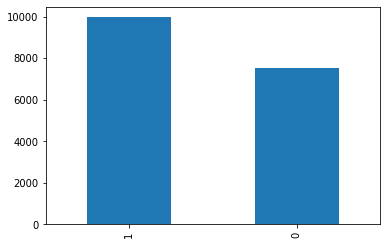

In [16]:
plt.figure(1)
df_train.user_suggestion.value_counts().plot(kind='bar')
plt.show()

# **Numerical variables**

In [17]:
for i, val in enumerate(df_train.isnull().any()):
  if val:
    print("The number of missing values in variable \"{}\" is {}".format(df_train.columns[i],df_train.isnull().sum()[i]))


The number of missing values in variable "year" is 178


Since we see, there are 178 missing values in column "year" (others are not missing), we will go in two directions. First, we let the value as a missing one or replace it with the use of some different inputational techniques - mode, median, and train neural net for imputing missing table data.

1. mode - for every category input the most frequent year

In [18]:
df_train.year

0        2016.0
1        2016.0
2        2016.0
3        2015.0
4        2015.0
          ...  
17489    2012.0
17490    2017.0
17491    2011.0
17492       NaN
17493       NaN
Name: year, Length: 17494, dtype: float64

Natrenujem embedding pomocou textu a vysledkov a to potom pouzijem do modelu

SPecialne najprv osetrit numericke premenne a potom kategorialne.

Na konci ked budem popisovat casovuspotrebu tak tam aj napisem ze z casoveho hladiska by som zvolil ten rychlejsi model atd

# **Categorical variables**


We have two categorical varibales **title** and also **user_review**. We will give a special attention to user_review, since it is a long string variable which potentianally carrie a lots of information.

In [19]:
print("Number of unique categories of \"title\" variable is {}".format(len(df_train.title.unique())))

Number of unique categories of "title" variable is 44


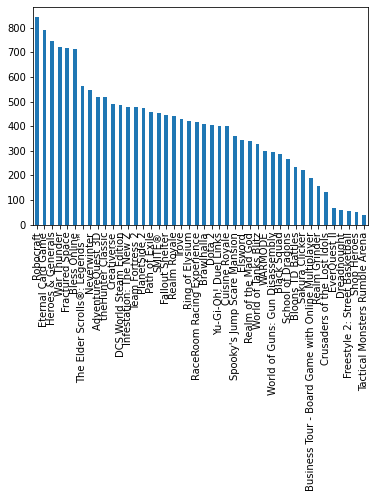

Robocraft                                             842
Eternal Card Game                                     791
Heroes & Generals                                     745
War Thunder                                           720
Fractured Space                                       718
Bless Online                                          712
The Elder Scrolls®: Legends™                          565
Neverwinter                                           546
AdventureQuest 3D                                     519
theHunter Classic                                     518
Creativerse                                           492
DCS World Steam Edition                               488
Infestation: The New Z                                479
Team Fortress 2                                       479
PlanetSide 2                                          472
Path of Exile                                         458
SMITE®                                                454
Fallout Shelte

In [20]:
plt.figure(1)
df_train.title.value_counts().plot(kind='bar')
plt.show()

df_train.title.value_counts()

So we see that we have categories with many observations and also categories with fewer ones. Since I plan to use Neural network, they normally do not have problems with too many categories if we have enough data. But from my experience, in terms of smaller datasets, what usually helps is to put the categories with less observation into one common category "Other". So we will try also to improve performace with this "shortcut".

In [21]:
#df_train.title.replace({'EverQuest II':'other', 'Dreadnought':'other', 'Freestyle 2: Street Basketball':'other', 'Shop Heroes':'other', 'Tactical Monsters Rumble Arena':'other'}, inplace=True)

#print("Number of unique categories of \"title\" variable is {}".format(len(df_train.title.unique())))

# **Overview**

In [22]:
df_overview.head()

,title,developer,publisher,tags,overview
0,Spooky's Jump Scare Mansion,Lag Studios,Lag Studios,"['Horror', 'Free to Play', 'Cute', 'First-Pers...",Can you survive 1000 rooms of cute terror? Or ...
1,Sakura Clicker,Winged Cloud,Winged Cloud,"['Nudity', 'Anime', 'Free to Play', 'Mature', ...",The latest entry in the Sakura series is more ...
2,WARMODE,WARTEAM,WARTEAM,"['Early Access', 'Free to Play', 'FPS', 'Multi...",Free to play shooter about the confrontation o...
3,Fractured Space,Edge Case Games Ltd.,Edge Case Games Ltd.,"['Space', 'Multiplayer', 'Free to Play', 'PvP'...",Take the helm of a gigantic capital ship and g...
4,Counter-Strike: Global Offensive,"Valve, Hidden Path Entertainment",Valve,"['FPS', 'Multiplayer', 'Shooter', 'Action', 'T...",Counter-Strike: Global Offensive (CS: GO) expa...


In [23]:
df_overview.dtypes

title        object
developer    object
publisher    object
tags         object
overview     object
dtype: object

We can see that in df_overview is other potential information, which we could use for train set. To be more specific - developer, publisher, tags, overview. Before that we check missing values. 

In [24]:
for i, val in enumerate(df_overview.isnull().any()):
  if val:
    print("The number of missing values in variable \"{}\" is {}".format(df_overview.columns[i],df_overview.isnull().sum()[i]))

In [25]:
for col in df_overview.columns:
    print( "The column %s has: %d categories" %(col,len(df_overview[col].unique())))

#print("Number of unique categories of \"title\" variable is {}".format(len(df_train.title.unique())))

The column title has: 64 categories
The column developer has: 59 categories
The column publisher has: 54 categories
The column tags has: 64 categories
The column overview has: 62 categories


.

In [26]:
df_train_merged = pd.merge(df_train, df_overview, on="title")

print(df_train_merged.shape)
df_train_merged.head()


(17494, 9)


,review_id,title,year,user_review,user_suggestion,developer,publisher,tags,overview
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1,Lag Studios,Lag Studios,"['Horror', 'Free to Play', 'Cute', 'First-Pers...",Can you survive 1000 rooms of cute terror? Or ...
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1,Lag Studios,Lag Studios,"['Horror', 'Free to Play', 'Cute', 'First-Pers...",Can you survive 1000 rooms of cute terror? Or ...
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1,Lag Studios,Lag Studios,"['Horror', 'Free to Play', 'Cute', 'First-Pers...",Can you survive 1000 rooms of cute terror? Or ...
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1,Lag Studios,Lag Studios,"['Horror', 'Free to Play', 'Cute', 'First-Pers...",Can you survive 1000 rooms of cute terror? Or ...
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1,Lag Studios,Lag Studios,"['Horror', 'Free to Play', 'Cute', 'First-Pers...",Can you survive 1000 rooms of cute terror? Or ...


postup:
1. nahradenie chybajucich dat, popripade vypustenie chybajucich riadkov
2. title bude one hot encoding
3. tagy spravit iba tokenizaciu 
4. user_review  - separatny embeddings 
5. overview - separatny embedding
6. developer, publisher - one hot

2. possibility
connect user_review + tags + overview


# **Submodel**

In [27]:
df_train_merged['text'] = df_train_merged.tags.apply(lambda x: x[1:-1]) + df_train_merged.overview + df_train_merged.user_review

X = df_train_merged
y = X.user_suggestion.values
X.head()

,review_id,title,year,user_review,user_suggestion,developer,publisher,tags,overview,text
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1,Lag Studios,Lag Studios,"['Horror', 'Free to Play', 'Cute', 'First-Pers...",Can you survive 1000 rooms of cute terror? Or ...,"'Horror', 'Free to Play', 'Cute', 'First-Perso..."
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1,Lag Studios,Lag Studios,"['Horror', 'Free to Play', 'Cute', 'First-Pers...",Can you survive 1000 rooms of cute terror? Or ...,"'Horror', 'Free to Play', 'Cute', 'First-Perso..."
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1,Lag Studios,Lag Studios,"['Horror', 'Free to Play', 'Cute', 'First-Pers...",Can you survive 1000 rooms of cute terror? Or ...,"'Horror', 'Free to Play', 'Cute', 'First-Perso..."
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1,Lag Studios,Lag Studios,"['Horror', 'Free to Play', 'Cute', 'First-Pers...",Can you survive 1000 rooms of cute terror? Or ...,"'Horror', 'Free to Play', 'Cute', 'First-Perso..."
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1,Lag Studios,Lag Studios,"['Horror', 'Free to Play', 'Cute', 'First-Pers...",Can you survive 1000 rooms of cute terror? Or ...,"'Horror', 'Free to Play', 'Cute', 'First-Perso..."


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [29]:
X_train_NN = X_train.text.values
X_test_NN = X_test.text.values

In [30]:
print("The longest sequence is {} words long.".format(max([len(x) for x in X_train_NN])))
pd.DataFrame([len(x) for x in X_train_NN]).describe()

The longest sequence is 12903 words long.


,0
count,11720.000000
mean,2782.665529
std,1437.665924
min,452.000000
25%,1851.000000
50%,2413.000000
75%,3439.500000
max,12903.000000


In [31]:
max_length = 5000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
vocab_size = 10000
#training_size = 20000

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train_NN)

print('Vocabulary is {} words large'.format(len(tokenizer.word_index)))

Vocabulary is 47213 words large


In [32]:
sorted(tokenizer.word_counts.items(), key = lambda t: t[1])[47000:]

[('fast', 3474),
 ('dcs', 3474),
 ('fly', 3514),
 ('updates', 3523),
 ('race', 3554),
 ("'survival'", 3558),
 ('never', 3563),
 ('digital', 3602),
 ('skill', 3635),
 ('long', 3635),
 ('choose', 3659),
 ('ai', 3738),
 ('everything', 3769),
 ('see', 3789),
 ('powerful', 3791),
 ('class', 3829),
 ('while', 3842),
 ('guns', 3856),
 ('single', 3879),
 ('earn', 3890),
 ('great', 3898),
 ('tank', 3909),
 ('who', 3919),
 ('these', 3928),
 ('tanks', 3966),
 ('including', 3985),
 ('eternal', 4022),
 ('then', 4056),
 ('pvp', 4068),
 ('multiplayer', 4081),
 ("'first", 4201),
 ('need', 4206),
 ("don't", 4241),
 ('me', 4248),
 ('find', 4254),
 ("'simulation'", 4257),
 ('pc', 4273),
 ('action', 4317),
 ('power', 4320),
 ('played', 4334),
 ('different', 4339),
 ('really', 4346),
 ('because', 4369),
 ('test', 4396),
 ('go', 4424),
 ('steam', 4482),
 ('keep', 4519),
 ('our', 4533),
 ('same', 4533),
 ('off', 4537),
 ('want', 4566),
 ('system', 4569),
 ("'fps'", 4607),
 ('well', 4646),
 ("'pvp'", 4648),
 

In [33]:
X_train_NN = tokenizer.texts_to_sequences(X_train_NN)
X_train_padded_NN = np.array(pad_sequences(X_train_NN, maxlen=max_length, padding=padding_type, truncating=trunc_type))

X_test_NN = tokenizer.texts_to_sequences(X_test_NN)
X_test_padded_NN = np.array(pad_sequences(X_test_NN, maxlen=max_length, padding=padding_type, truncating=trunc_type))

#y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
#y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [44]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model = tf.keras.Sequential()

model.add(Embedding(vocab_size,240, input_length = max_length))
model.add(Bidirectional(keras.layers.LSTM(64, return_sequences=True)))
model.add(Bidirectional(keras.layers.LSTM(32, return_sequences=True)))
model.add(Flatten()),
Dropout(0.5),
model.add(Dense(1,activation = 'sigmoid'))


model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics = METRICS)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 5000, 240)         2400000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 5000, 128)        156160    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 5000, 64)         41216     
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 320000)            0         
                                                                 
 dense_1 (Dense)             (None, 1)                 320001    
                                                                 
Total params: 2,917,377
Trainable params: 2,917,377
No

In [45]:
history = model.fit(X_train_padded_NN, y_train, epochs=1, validation_data=(X_test_padded_NN, y_test), verbose = 1)

367/367 [==============================] - 798s 2s/step - loss: 0.5210 - accuracy: 0.7510 - precision: 0.7628 - recall: 0.8140 - val_loss: 0.3746 - val_accuracy: 0.8377 - val_precision: 0.8387 - val_recall: 0.8890


In [47]:
X_train_pred = model.predict(X_train_padded_NN)
X_test_pred = model.predict(X_test_padded_NN)

Need to imput missing data for later work with decisiontree, Logisticregression.

In [63]:
from sklearn.impute import KNNImputer
import numpy as np

def knn_inputer(X):

    X[X.isnull()] = np.nan

    imputer = KNNImputer(n_neighbors=2)
    X_im = imputer.fit_transform(X)
    return pd.DataFrame(X_im, columns = list(X.columns))

def process_dat(X):
  
  X_1 = X.loc[:,['title','developer','publisher']]
  X_1 = pd.get_dummies(X_1)
  X_1 = pd.concat([X_1,X.loc[:,['review_id','year']]], axis = 1)

  return X_1

X_trainm = process_dat(X_train)
X_trainm = knn_inputer(X_trainm)
X_trainm['predictions'] = [x[0] for x in X_train_pred.tolist()]

X_testm = process_dat(X_test)
X_testm = knn_inputer(X_testm)
X_testm['predictions'] = [x[0] for x in X_test_pred.tolist()]

print(X_trainm.isnull().sum())
print(X_testm.isnull().sum())

title_AdventureQuest 3D               0
title_Black Squad                     0
title_Bless Online                    0
title_Bloons TD Battles               0
title_Brawlhalla                      0
                                     ..
publisher_Wargaming Group Limited     0
publisher_Winged Cloud                0
review_id                             0
year                                  0
predictions                           0
Length: 129, dtype: int64
title_AdventureQuest 3D               0
title_Black Squad                     0
title_Bless Online                    0
title_Bloons TD Battles               0
title_Brawlhalla                      0
                                     ..
publisher_Wargaming Group Limited     0
publisher_Winged Cloud                0
review_id                             0
year                                  0
predictions                           0
Length: 129, dtype: int64


In [64]:
def XGB_function(X_train, y_train, X_test, y_test, X):
  # 0 - home, 1 - draw, 2 - away

  xgb_cl = xgb.XGBClassifier(n_estimators=15,learning_rate=0.5,max_delta_step=5)
  xgb_cl.fit(X_train,y_train)

  if ( not(X_test is None) and not(y_test is None)):
    print('Accuracy of Extreme boosted classifier on training set: {:.2f}'.format(xgb_cl.score(X_train, y_train)))
    print('Accuracy of Extreme boosted classifier on test set: {:.2f}'.format(xgb_cl.score(X_test, y_test)))

  return xgb_cl.predict(X), xgb_cl.predict_proba(X)

In [65]:
import xgboost as xgb

_ , probabilities_train = XGB_function(X_trainm, y_train, X_testm, y_test, X_trainm)
_ , probabilities_test = XGB_function(X_trainm, y_train, X_testm, y_test, X_testm)

Accuracy of Extreme boosted classifier on training set: 0.89
Accuracy of Extreme boosted classifier on test set: 0.86
Accuracy of Extreme boosted classifier on training set: 0.89
Accuracy of Extreme boosted classifier on test set: 0.86


In [66]:
X_1 = pd.DataFrame(probabilities_train)
X_1['pred'] = X_trainm.predictions.values
X_1

X_2 = pd.DataFrame(probabilities_test)
X_2['pred'] = X_testm.predictions.values
X_2
#X_testm 

,0,1,pred
0,0.572899,0.427101,0.399367
1,0.938667,0.061333,0.110252
2,0.024630,0.975370,0.974405
3,0.157025,0.842975,0.885759
4,0.587025,0.412975,0.513368
...,...,...,...
5769,0.926389,0.073611,0.168908
5770,0.010517,0.989483,0.999590
5771,0.009580,0.990420,0.950008
5772,0.967172,0.032828,0.072032


In [67]:
from sklearn.linear_model import LogisticRegression

def LogisticRegression_function(X_train, y_train, X_test, y_test, X):
  # 0 - home, 1 - draw, 2 - away

  logreg = LogisticRegression()
  logreg.fit(X_train, y_train)

  if ( not(X_test is None) and not(y_test is None)):
    print('Accuracy of Logistic regression classifier on training set: {:.2f}'.format(logreg.score(X_train, y_train)))
    print('Accuracy of Logistic regression on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

  return logreg.predict(X), logreg.predict_proba(X)

In [68]:
LogisticRegression_function(X_1, y_train, X_2, y_test, X_2)

Accuracy of Logistic regression classifier on training set: 0.89
Accuracy of Logistic regression on test set: 0.86


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

(array([0, 0, 1, ..., 1, 0, 1]), array([[0.60157612, 0.39842388],
        [0.94942329, 0.05057671],
        [0.04011987, 0.95988013],
        ...,
        [0.03463848, 0.96536152],
        [0.95720666, 0.04279334],
        [0.03939538, 0.96060462]]))

In [69]:
from sklearn.tree import DecisionTreeClassifier

def DecisionTree_function(X_train, y_train, X_test, y_test, X):
  # 0 - home, 1 - draw, 2 - away

  clf = DecisionTreeClassifier()
  clf.fit(X_train, y_train)

  if ( not(X_test is None) and not(y_test is None)):
    print('Accuracy of DecisionTree classifier on training set: {:.2f}'.format(clf.score(X_train, y_train)))
    print('Accuracy of DecisionTree on test set: {:.2f}'.format(clf.score(X_test, y_test)))

  return clf.predict(X), clf.predict_proba(X)

In [70]:
DecisionTree_function(X_trainm, y_train, X_testm, y_test, X_trainm)

Accuracy of DecisionTree classifier on training set: 1.00
Accuracy of DecisionTree on test set: 0.84


(array([0, 1, 1, ..., 0, 1, 1]), array([[1., 0.],
        [0., 1.],
        [0., 1.],
        ...,
        [1., 0.],
        [0., 1.],
        [0., 1.]]))

[[1903  548]
 [ 567 2756]]


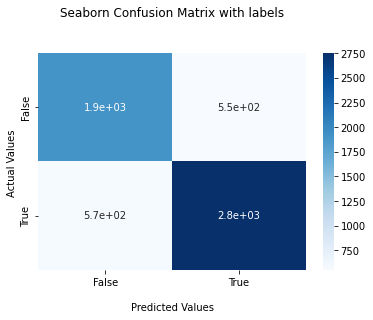

In [71]:
# Example of a confusion matrix in Python
from sklearn.metrics import confusion_matrix

#first is category 0 then catgory 1. Check:
#np.logical_and((y_test ==1),np.array([x[0] for x in (round(X_test_p) == 1).values])).sum()

results = confusion_matrix(y_test, round(X_test_p))
print(results)

import seaborn as sns

ax = sns.heatmap(results, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve

In [ ]:
def draw_precision_recall_curve(model, sequences, labels):
  """
  RETURN: precision (x-axis) - recall (y-axis) curve in graph with the 
  value of AUC   
  """
    
  probs = model.predict(sequences)
  precision, recall, thresholds = precision_recall_curve(labels, probs)
  plt.plot(recall, precision, marker='.', label='My model')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend(loc="lower center")
  plt.title('Precision recall curve')
  auc_precision_recall = auc(recall, precision)
  print("AUC-PR:", auc_precision_recall)
  plt.show()



def ROC_curve(model, sequences, labels):
  """
  RETURN: ROC (FPR (x-axis) - TPR curve (y-axis)) curve in graph with the 
  value of AUC   
  """

  probs = model.predict(sequences)
  fpr, tpr, thresholds = roc_curve(labels, probs)
  auc_score = roc_auc_score(labels, probs)
  print("AUC score: ", auc_score)
  figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
  plt.plot(fpr, tpr, 'blue', label='My model')
  plt.axis([0, 1, 0, 1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower center")
  plt.title('ROC curve')
  plt.show()


def f1_m(model, sequences, labels):
  """
  RETURN: thrasholds and value of F1    
  """

  predictions = model.predict(sequences)
  precision, recall, thresholds = precision_recall_curve(labels, predictions)
  
  f1  = 2 * ( (precision * recall ) / (precision + recall))

  return (thresholds, f1)


def f1_graph(model, sequences, labels):
  """
  RETURN: graph of F1 values (on y - axis) and thresholds values on (x - axis)   
  """

  predictions = model.predict(sequences)
  precision, recall, thresholds = precision_recall_curve(labels, predictions)
  
  f1  = 2 * ( (precision * recall ) / (precision + recall))

  plt.plot(thresholds, f1[0: thresholds.shape[0]], 'blue', label='My model')
  plt.xlabel('Thresholds')
  plt.ylabel('F1')
  plt.legend(loc="lower center")
  plt.title('F1 curve')
  plt.show()



def diag_graphs(model, sequences, labels):

  probs = model.predict(sequences)
  precision, recall, thresholds = precision_recall_curve(labels, probs)
  fpr, tpr, thresholds = roc_curve(labels, probs)
  thresholds, f1 = f1_m(model, sequences, labels)  

  figure1, axis = plt.subplots(2, 2, squeeze=False)
  figure1.tight_layout(pad=3.0)
  
  # For Precision - Recall graph
  axis[0, 0].plot(recall, precision, label='My model')
  axis[0, 0].set_xlabel('Recall')
  axis[0, 0].set_ylabel('Precision')
  axis[0, 0].set_title('Precision recall curve')
  
  # For FPR - TPR graphs
  axis[0, 1].plot(fpr, tpr,  label='My model')
  axis[0, 1].set_xlabel('False Positive Rate')
  axis[0, 1].set_ylabel('True Positive Rate')
  axis[0, 1].set_title('ROC curve')
  
  # For F1 graph
  axis[1, 0].plot(thresholds, f1[0:thresholds.shape[0]],  label='My model')
  axis[1, 0].set_xlabel('Thresholds')
  axis[1, 0].set_ylabel('F1')
  axis[1, 0].set_title('F1 curve')

  # Combine all the operations and display
  plt.show()

  auc_score = roc_auc_score(labels, probs)
  print("AUC score for (TPR, FPR) - graph: ", round(auc_score,4))

  auc_precision_recall = auc(recall, precision)
  print("AUC-PR for (precision - recall) graph:", round(auc_precision_recall,4))
